# Setup

In [280]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
from pandas import DataFrame

In [281]:
#grab random 200,000 entries from the original file, put them in a new csv called 'data.csv'

import random
FILE='read_data_5.csv'
data = pd.read_csv(FILE)

# n =  len(data)
# s = 200000 
# skip = sorted(random.sample(range(1,n+1),n-s)) 
# data = pd.read_csv(FILE, skiprows=skip)
data.to_csv("data.csv", index=False)

In [282]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129832 entries, 0 to 129831
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   StartTime  129832 non-null  object 
 1   Dur        129832 non-null  float64
 2   Proto      129832 non-null  object 
 3   SrcAddr    129832 non-null  object 
 4   Sport      129035 non-null  object 
 5   Dir        129832 non-null  object 
 6   DstAddr    129832 non-null  object 
 7   Dport      129455 non-null  object 
 8   State      129832 non-null  object 
 9   sTos       128974 non-null  float64
 10  dTos       122936 non-null  float64
 11  TotPkts    129832 non-null  int64  
 12  TotBytes   129832 non-null  int64  
 13  SrcBytes   129832 non-null  int64  
 14  Label      129832 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 14.9+ MB
None


# Clean the Data

##  Drop missing entries

In [283]:
#Drop any rows with missing data

data.dropna(inplace = True)

## Convert all the data to numerical values

In [284]:
#Set Dummy Values

labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(data['Proto'])
data['Proto'] = labelEncoder.transform(data['Proto'])

labelEncoder.fit(data['State'])
data['State'] = labelEncoder.transform(data['State'])

labelEncoder.fit(data['Dir'])
data['Dir'] = labelEncoder.transform(data['Dir'])


In [285]:
#convert StartTime to epoch

start_time = data['StartTime'].tolist()

for index in range(0, len(start_time)):
    start_time[index] = pd.to_datetime(start_time[index]).timestamp() 
    
data['StartTime'] = start_time 


In [286]:
#Convert dst/src addresses to numerical values (delete the row if the value cannot be converted)

src_addr = data['SrcAddr'].tolist()
dst_addr = data['DstAddr'].tolist()

for index in range(0, len(src_addr)):
    try:
        src_addr[index] = int(str(src_addr[index]).replace('.', ''))
    except: 
        data = data.drop(data.index[index])
    
for index in range(0, len(dst_addr)):
    try: 
        dst_addr[index] = int(str(dst_addr[index]).replace('.', ''))
    except: 
        data = data.drop(data.index[index])
    
data["SrcAddr"] = src_addr
data["DstAddr"] = dst_addr
data.to_csv("data.csv", index=False)



In [287]:
#Convert Sport and Dport to numerical values

rows = list(data['Sport'])
for row_index in range(0, len(rows)):
    try:
        rows[row_index] = row[row_index].astype(np.float32)
    except:
        rows[row_index] = 0
data['Sport'] = rows


rows = list(data['Dport'])
for row_index in range(0, len(rows)):
    try:
        rows[row_index] = rows[row_index].astype(np.float32)
    except:
        rows[row_index] = 0
data['Dport'] = rows

In [288]:
# Convert Label column to numerical values. 1 if botnet, 0 if benign. 
# Store the botnet and benign flows in separate csv files.


# create a list of all the labels
label_entries = list(data['Label'])

#create lists for storing botnet and benign flows
botnets = list()
benign = list()

#convert botnet entries to 1, benign to 0
index = 0
for entry in data['Label']:
    # non-TCP and UDP protocols are outliers too, so remove them
    if not 'TCP' in entry and not 'UDP' in entry:
        label_entries[index] = -1
    else:
        if 'botnet' in entry or 'Botnet' in entry:
            label_entries[index] = 1

        else:
            if not entry == 1 and not entry == 0:
                label_entries[index] = 0
    index += 1
        
data['Label'] = label_entries
data.to_csv("data.csv", index=False)


# Store the benign and botnet data in separate arrays
# Convert benign and botnet to dataframes, save in csv files

index = 0
for entry in data['Label']:
    if entry == 1:
        botnets.append(list(data.iloc[index]))
    elif entry == 0:
        benign.append(list(data.iloc[index]))
    index += 1

benign = DataFrame (benign,columns=list(data.columns))
botnets = DataFrame (botnets,columns=list(data.columns))

botnets.to_csv("botnet.csv", index=False)
benign.to_csv("benign.csv", index=False)
        


In [289]:
#remove outliers

from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std


no_outliers = list()
outliers = list()

#loop through each relevant column to find the outliers
for name in ['Dur', 'TotBytes', 'SrcBytes', 'TotPkts']:
    
    col = benign[name]
    
    # calculate summary statistics
    data_mean, data_std = mean(col), std(col)
    
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    # find locations of the outliers
    index = 0
    for x in col:
        #check for protocol outliers
        if name == 'Label':
            if x == -1:
                outliers.append(index)
                
        if x < lower or x > upper:
            outliers.append(index)
        index += 1
    
#remove duplicates
outliers = list(dict.fromkeys(outliers))   


In [290]:
# Combine the reduced list of benign flows with the botnet flows
# Convert the list to csv

no_outliers = DataFrame (pd.concat([benign.drop(benign.index[outliers]), botnets], ignore_index=True))

no_outliers.to_csv("no_outliers.csv", index=False)
    

# Visualize Data

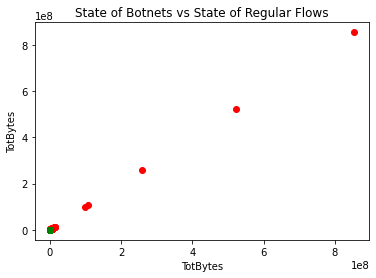

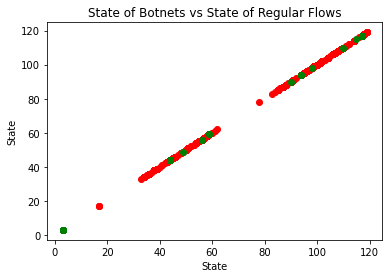

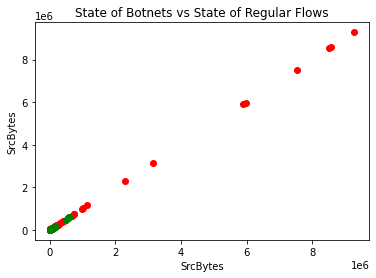

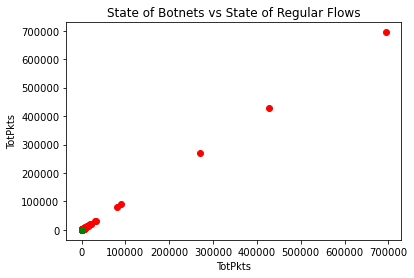

In [291]:
from matplotlib import pyplot as plt
# TotBytes
plt.title("State of Botnets vs State of Regular Flows")
plt.xlabel("TotBytes")
plt.ylabel("TotBytes")
plt.scatter(data.loc[data['Label'] == 0]['TotBytes'],data.loc[data['Label'] == 0]['TotBytes'],color='red')
plt.scatter(data.loc[data['Label'] == 1]['TotBytes'],data.loc[data['Label'] == 1]['TotBytes'],color='green')
plt.show()

plt.title("State of Botnets vs State of Regular Flows")
plt.xlabel("State")
plt.ylabel("State")
plt.scatter(data.loc[data['Label'] == 0]['State'],data.loc[data['Label'] == 0]['State'],color='red')
plt.scatter(data.loc[data['Label'] == 1]['State'],data.loc[data['Label'] == 1]['State'],color='green')
plt.show()

plt.title("State of Botnets vs State of Regular Flows")
plt.xlabel("SrcBytes")
plt.ylabel("SrcBytes")
plt.scatter(data.loc[data['Label'] == 0]['SrcBytes'],data.loc[data['Label'] == 0]['SrcBytes'],color='red')
plt.scatter(data.loc[data['Label'] == 1]['SrcBytes'],data.loc[data['Label'] == 1]['SrcBytes'],color='green')
plt.show()

plt.title("State of Botnets vs State of Regular Flows")
plt.xlabel("TotPkts")
plt.ylabel("TotPkts")
plt.scatter(data.loc[data['Label'] == 0]['TotPkts'],data.loc[data['Label'] == 0]['TotPkts'],color='red')
plt.scatter(data.loc[data['Label'] == 1]['TotPkts'],data.loc[data['Label'] == 1]['TotPkts'],color='green')
plt.show()

# K-Means Clustering

In [292]:
from sklearn.cluster import KMeans

#get all the features except StartTime and Label
x = no_outliers.iloc[:,1:14]


10
20
30
40
50
10


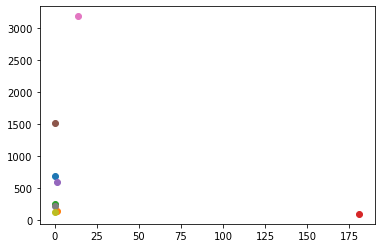

20


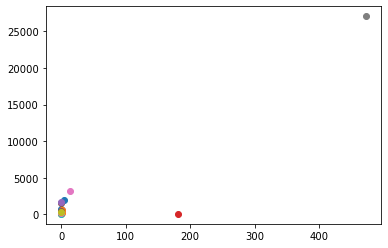

30


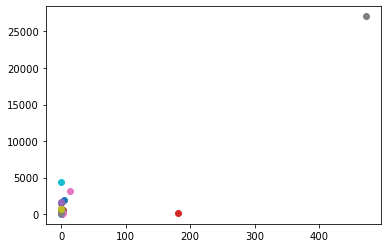

40


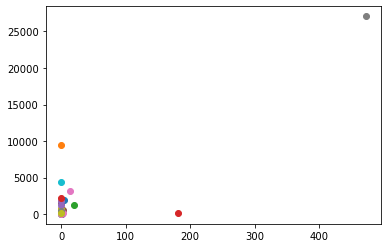

50


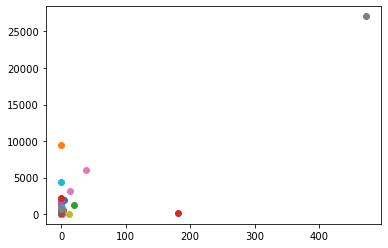

In [293]:
#counts the number of botnets and benign flows in each cluster
def count_groups(n, clusters):
    
    # Make a list of dictionaries for storing counts of botnet and benign flows
    counts = list()
    for index in range(0, n):
        counts.append( {'botnet': 0, 'benign': 0} )
        
    for index in range(0, len(clusters)):
        
        # if it's benign
        if int(no_outliers['Label'][index]) == 0:
            counts[clusters[index]]['benign'] += 1
        # if it's a botnet
        else:
            counts[clusters[index]]['botnet'] += 1
            
    return counts


# Test on 1 - 50 Clusters
NUM_CLUSTERS = 50
for num in range(10, NUM_CLUSTERS + 1, 10):
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(x)
    identified_clusters = kmeans.fit_predict(x)
    clusters_set = count_groups(num, identified_clusters)
    print(num)

# Plot the botnet vs benign for each cluster
for n in range(10, len(clusters_set)+1, 10):
    print(n)
    for cluster in range(1, n):
        plt.scatter(clusters_set[cluster]['botnet'], clusters_set[cluster]['benign'])
    plt.show()






In [294]:
# List Clusters
NUM_CLUSTERS = 50
for num in range(10, NUM_CLUSTERS + 1, 10):
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(x)
    centroids  = kmeans.cluster_centers_
    print("%d clusters, centroids: " % (num))
    print(centroids)

10 clusters, centroids: 
[[ 4.57615869e+01  3.40092990e+00  8.74754889e+08  0.00000000e+00
   8.07224607e-01  1.60690852e+10  0.00000000e+00  3.43376252e+01
   9.32413868e-18  2.68240343e-03  2.42035050e+01  1.68235953e+04
   1.30558351e+03]
 [ 3.38642521e+01  3.91537545e+00  1.18843801e+11  0.00000000e+00
   1.84505364e+00  1.39205173e+09  0.00000000e+00  8.04648391e+00
  -5.20417043e-18  1.62630326e-18  8.55184744e+00  4.14908105e+03
   3.77768772e+02]
 [ 1.28975320e+01  3.88400617e+00  9.42345059e+08  0.00000000e+00
   1.77006977e+00  5.26432163e+08  0.00000000e+00  9.96530077e+00
   8.96825501e-04  4.35224140e-04  6.85083682e+00  3.95819218e+03
   3.45582818e+02]
 [ 6.17422961e+01  3.96259352e+00  1.41541850e+09  0.00000000e+00
   1.95012469e+00  1.20651550e+11  0.00000000e+00  5.21197007e+00
   3.46944695e-18  1.08420217e-19  3.77556110e+00  1.37850623e+03
   2.04082294e+02]
 [ 3.21939527e+01  3.83285094e+00  1.97199133e+11  0.00000000e+00
   1.67004342e+00  1.41686885e+09  0.0000

40 clusters, centroids: 
[[ 4.31976714e+01  3.90079893e+00  8.72720478e+09  0.00000000e+00
   1.81979583e+00  1.42040495e+09  0.00000000e+00  9.60075455e+00
   7.10164225e-03 -6.61363325e-18  5.78872614e+00  2.11175411e+03
   3.18612517e+02]
 [ 3.16225996e+01  3.93887531e+00  1.10982639e+11  0.00000000e+00
   1.90709046e+00  1.36630006e+09  0.00000000e+00  6.53300733e+00
   3.46944695e-18  2.16840434e-19  4.41564792e+00  1.58198044e+03
   2.27044010e+02]
 [ 3.71766881e+01  3.49700599e+00  1.02627062e+09  0.00000000e+00
   9.94011976e-01  1.73452183e+11  0.00000000e+00  3.79101796e+01
   6.50521303e-19 -3.25260652e-19  4.27245509e+01  3.37683473e+04
   2.69347305e+03]
 [ 3.22652741e+01  3.34746922e+00  1.21915877e+09  0.00000000e+00
   7.03146375e-01  9.39150903e+10  0.00000000e+00  4.45663475e+01
   3.90312782e-18  1.36798906e-02  5.83939808e+01  6.09976389e+04
   1.59691518e+03]
 [ 4.04266489e+01  3.91329480e+00  1.89266543e+11  0.00000000e+00
   1.82658960e+00  1.42308189e+09  0.0000

50 clusters, centroids: 
[[ 1.62244724e+00  3.92931545e+00  1.34861946e+08  0.00000000e+00
   1.85863090e+00  2.41332944e+07  0.00000000e+00  6.54851071e+00
  -2.43078127e-16  1.04511409e-04  5.28360913e+00  2.88357297e+03
   2.61275980e+02]
 [ 4.04266489e+01  3.91329480e+00  1.89266543e+11  0.00000000e+00
   1.82658960e+00  1.42308189e+09  0.00000000e+00  8.89884393e+00
   8.67052023e-03 -2.16840434e-19  5.49421965e+00  9.40815029e+02
   3.37473988e+02]
 [ 3.35881410e+01  3.42398287e+00  1.37618106e+09  0.00000000e+00
   8.60813704e-01  9.53556444e+10  0.00000000e+00  4.91263383e+01
  -1.95156391e-18  1.08420217e-19  5.14989293e+01  6.20347666e+04
   1.15281585e+03]
 [ 3.69441605e+01  3.88235294e+00  9.37547572e+10  0.00000000e+00
   1.80622837e+00  1.44070894e+09  0.00000000e+00  1.04238754e+01
   1.90311419e-02  1.95156391e-18  4.08996540e+00  6.29022491e+02
   2.86510381e+02]
 [ 3.03268696e+01  3.24115756e+00  1.39227741e+09  0.00000000e+00
   4.82315113e-01  2.11301582e+11  0.0000

In [295]:
# Find the Cluster with the most botnets for each iteration

# Test on 1 - 50 Clusters
NUM_CLUSTERS = 50
for num in range(10, NUM_CLUSTERS + 1, 10):
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(x)
    identified_clusters = kmeans.fit_predict(x)
    clusters_set = count_groups(num, identified_clusters)
    max_botnet = 0
    max_benign = 0
    
    for dictionary in clusters_set:
        if max_botnet < dictionary['botnet']:
            max_botnet = dictionary['botnet']
            max_benign = dictionary['benign']
    print("With %d clusters, the cluster contains %d botnets and %d benign" % (num, max_botnet, max_benign))


With 10 clusters, the cluster contains 520 botnets and 74219 benign
With 20 clusters, the cluster contains 510 botnets and 72090 benign
With 30 clusters, the cluster contains 475 botnets and 28491 benign
With 40 clusters, the cluster contains 475 botnets and 27203 benign
With 50 clusters, the cluster contains 475 botnets and 27195 benign


In [296]:
# Find silhouette values for various numbers of clusters
from sklearn.metrics import silhouette_score

NUM_CLUSTERS=50
for num in range(10, NUM_CLUSTERS + 1, 10):
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(x)
    labels=kmeans.labels_
    silhouette = silhouette_score(x, labels)
    print("%d clusters, silhouette score: %f" % (num, silhouette))
        

10 clusters, silhouette score: 0.787944
20 clusters, silhouette score: 0.813118
30 clusters, silhouette score: 0.771511
40 clusters, silhouette score: 0.760987
50 clusters, silhouette score: 0.780692


# Debugging

In [297]:
print(len(no_outliers))
print(len(botnets))
print(len(benign))
print(len(data))

100576
749
103644
122149


# Useful Resources:

https://www.geeksforgeeks.org/convert-a-categorical-variable-into-dummy-variables/?ref=rp